In [1]:
import numpy as np 
import pandas as pd
from scipy.special import softmax 
import time 
import copy

from copy import deepcopy

import loss4arbitration_fit as agent

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 



class two_stage:
    nS = 9
    nA = 2
    nC = 2 
    nR = 3
    s_termination = list(range(5,9))
    
    def __init__(self,seed=873):
        '''A MDP is a 5-element-tuple

        S: state space
        A: action space
        T: transition function
        C: certainty
        R: reward condition
        '''
        self.rng = np.random.RandomState(seed)
        self.nS = two_stage.nS
        self.nA = two_stage.nA
        self.nC = two_stage.nC 
        self._init_state()
        self._init_action()
        self._init_trans_fn()
        self._init_reward()


    
    def _init_state(self):
        self.S  = np.arange(two_stage.nS)

    def _init_action(self):
        self.A  = np.arange(two_stage.nA)

    def _init_certainty(self):
        self.C  = np.arange(two_stage.nC)

    def _init_reward(self):
        self.R  = np.arange(two_stage.nR)

    def _init_trans_fn(self):
        '''T(s'|s,a)'''
        def pro(C):
            if C == 0:
                prob = 0.9
            elif C == 1:
                prob = 0.5
            return prob
        
        self.t = {
                0: {0: {0: [0, pro(0), 1-pro(0), 0, 0, 0, 0, 0, 0],
                        1: [0, pro(1), 1-pro(1), 0, 0, 0, 0, 0, 0]},
                    1: {0: [0, 0, 0, pro(0), 1-pro(0), 0, 0, 0, 0],
                        1: [0, 0, 0, pro(1), 1-pro(1), 0, 0, 0, 0]},},

                1: {0: {0: [0, 0, 0, 0, 0, 0, 1-pro(0), pro(0), 0],
                        1: [0, 0, 0, 0, 0, 0, 1-pro(1), pro(1), 0]},
                    1: {0: [0, 0, 0, 0, 0, 1-pro(0), pro(0), 0, 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), pro(1), 0, 0]},},

                2: {0: {0: [0, 0, 0, 0, 0, 1-pro(0), pro(0), 0, 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), pro(1), 0, 0]},
                    1: {0: [0, 0, 0, 0, 0, 1-pro(0), 0, pro(0), 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), 0, pro(1), 0]},},
                
                3: {0: {0: [0, 0, 0, 0, 0, 0, 0, pro(0), 1-pro(0)],
                        1: [0, 0, 0, 0, 0, 0, 0, pro(1), 1-pro(1)]},
                    1: {0: [0, 0, 0, 0, 0, 1-pro(0), 0, 0, pro(0)],
                        1: [0, 0, 0, 0, 0, 1-pro(1), 0, 0, pro(1)]},},

                4: {0: {0: [0, 0, 0, 0, 0, 1-pro(0), 0, pro(0), 0],
                        1: [0, 0, 0, 0, 0, 1-pro(1), 0, pro(1), 0]},
                    1: {0: [0, 0, 0, 0, 0, pro(0), 0, 0, 1-pro(0)],
                        1: [0, 0, 0, 0, 0, pro(1), 0, 0, 1-pro(1)]},},
                }

        
    def trans_fn(self,s,a,C):
        self.T = self.t[s][a][C]
        return self.T         
    
    def _init_reward(self):
        '''R(r|s',a)''' 
    
        self.r = {
                    0:[0,0,0,0,0,0,10,20,40],
                    1:[0,0,0,0,0,0,10,0,0],
                    2:[0,0,0,0,0,0,0,20,0],
                }   
          
    def reward_fn(self,W,s):
        self.R = self.r[W][s]
        return self.R
    
    def reset(self):
        '''always start with state=0
        '''
        self.s = 0
        self.done = False 
        return self.s 
    
    def step(self,a,C,W):
        
        # get next state 
        p_s_next = self.trans_fn(self.s,a,C)
        s_next = self.rng.choice(self.S, p=p_s_next)
        # get the reward
        obj_r = self.reward_fn(W,s_next)
        # check the termination
        if s_next > 4: self.done = True 
        # move on 
        self.s = s_next 

        return self.s, obj_r, self.done




## Comparison Curves

### Simulation

In [2]:
# ---------- Optimality helpers ----------

def _expected_reward(env: two_stage, s: int, a: int, C: int, W: int) -> float:
    p = np.asarray(env.t[s][a][C], dtype=float)
    r = np.asarray(env.r[W],       dtype=float)
    return float(np.dot(p, r))

def _optimal_a2(env: two_stage, s2: int, C: int, W: int):
    qs = [_expected_reward(env, s2, a, C, W) for a in range(env.nA)]
    a_star = int(np.argmax(qs))
    return a_star, qs

def _optimal_a1(env: two_stage, C: int, W: int):
    """
    第一阶段在 s0=0 时的最优动作。
    先对每个二阶段状态 s2∈{1,2,3,4}，求其最优 a2 的期望回报 V(s2)；
    再计算 Q(s0,a1) = sum_{s2} P(s2|s0,a1,C) * V(s2)，选 a1* = argmax Q。
    """
    # 计算每个二阶段状态的最优价值
    V = {}
    for s2 in (1, 2, 3, 4):
        a2_star, _ = _optimal_a2(env, s2, C, W)
        V[s2] = _expected_reward(env, s2, a2_star, C, W)

    # 用 V 反推第一阶段每个动作的 Q 值
    qs = []
    for a1 in range(env.nA):
        p_s2 = np.asarray(env.t[0][a1][C], dtype=float)  # 下一步到各 s 的概率
        q = sum(p_s2[s2] * V[s2] for s2 in (1, 2, 3, 4))
        qs.append(q)
    a_star = int(np.argmax(qs))
    return a_star, qs

# ---------- Simulation with optimality tracking ----------

def sim(agent_fn, params, n_episode=150, seed=873):
    cols = ['optimal_action', 'optimal_rate', 'accumulated_reward']
    sim_data = {col: [] for col in cols}
    nS, nA = 9, 2
    rng = np.random.RandomState(seed)
    env = two_stage(seed=seed)
    agent = agent_fn(nS, nA, rng, params=params)

    total_r = 0
    opt_cnt = 0      # 累计“选到最优”的次数（每 trial 最多 +2：stage1 + stage2）
    prev_goal = None

    # block 设定与原逻辑一致（C: 0→0.9, 1→0.5；W 是奖励条件）
    for t in range(n_episode):
        if t < 37:
            goal, certainty = 2, 0
        elif t < 75:
            goal, certainty = 0, 0
        elif t < 112:
            goal, certainty = 1, 1
        else:
            goal, certainty = 0, 1

        # block 变更 → 回溯规划
        if goal != prev_goal:
            agent.back_plan(goal)
            prev_goal = goal

        # ---- Stage 1 ----
        s1 = env.reset() 
        
        a1 = rng.choice(nA, p=agent.make_move(s1))

        # 计算理论最优 a1*
        a1_star, _ = _optimal_a1(env, certainty, goal)
        if a1 == a1_star:
            opt_cnt += 1

        # ---- Stage 2 ----
        s2, r1, done = env.step(a1, C=certainty, W=goal)

        a2 = rng.choice(nA, p=agent.make_move(s2))

        # 理论最优 a2*
        a2_star, _ = _optimal_a2(env, s2, certainty, goal)
        if a2 == a2_star:
            opt_cnt += 1

        # ---- Terminal ----
        s3, r2, done = env.step(a2, C=certainty, W=goal)
        agent.learn(s1, a1, s2, r1, a2, s3, r2, goal)

        total_r += r2

        # 记录曲线
        sim_data['optimal_action'].append(opt_cnt)
        sim_data['optimal_rate'].append(opt_cnt / (2*(t+1)))
        sim_data['accumulated_reward'].append(total_r)

    return sim_data


### Generate data, average over 200 parameter sets

[lossarbi] running 200 reps …
[larbi] running 200 reps …
[MF] running 200 reps …
[MB] running 200 reps …
[random] running 200 reps …
[larbi_mini] running 200 reps …
[hybrid] running 200 reps …
Split by 'Q': HC=46  MUD=53  ALL=99


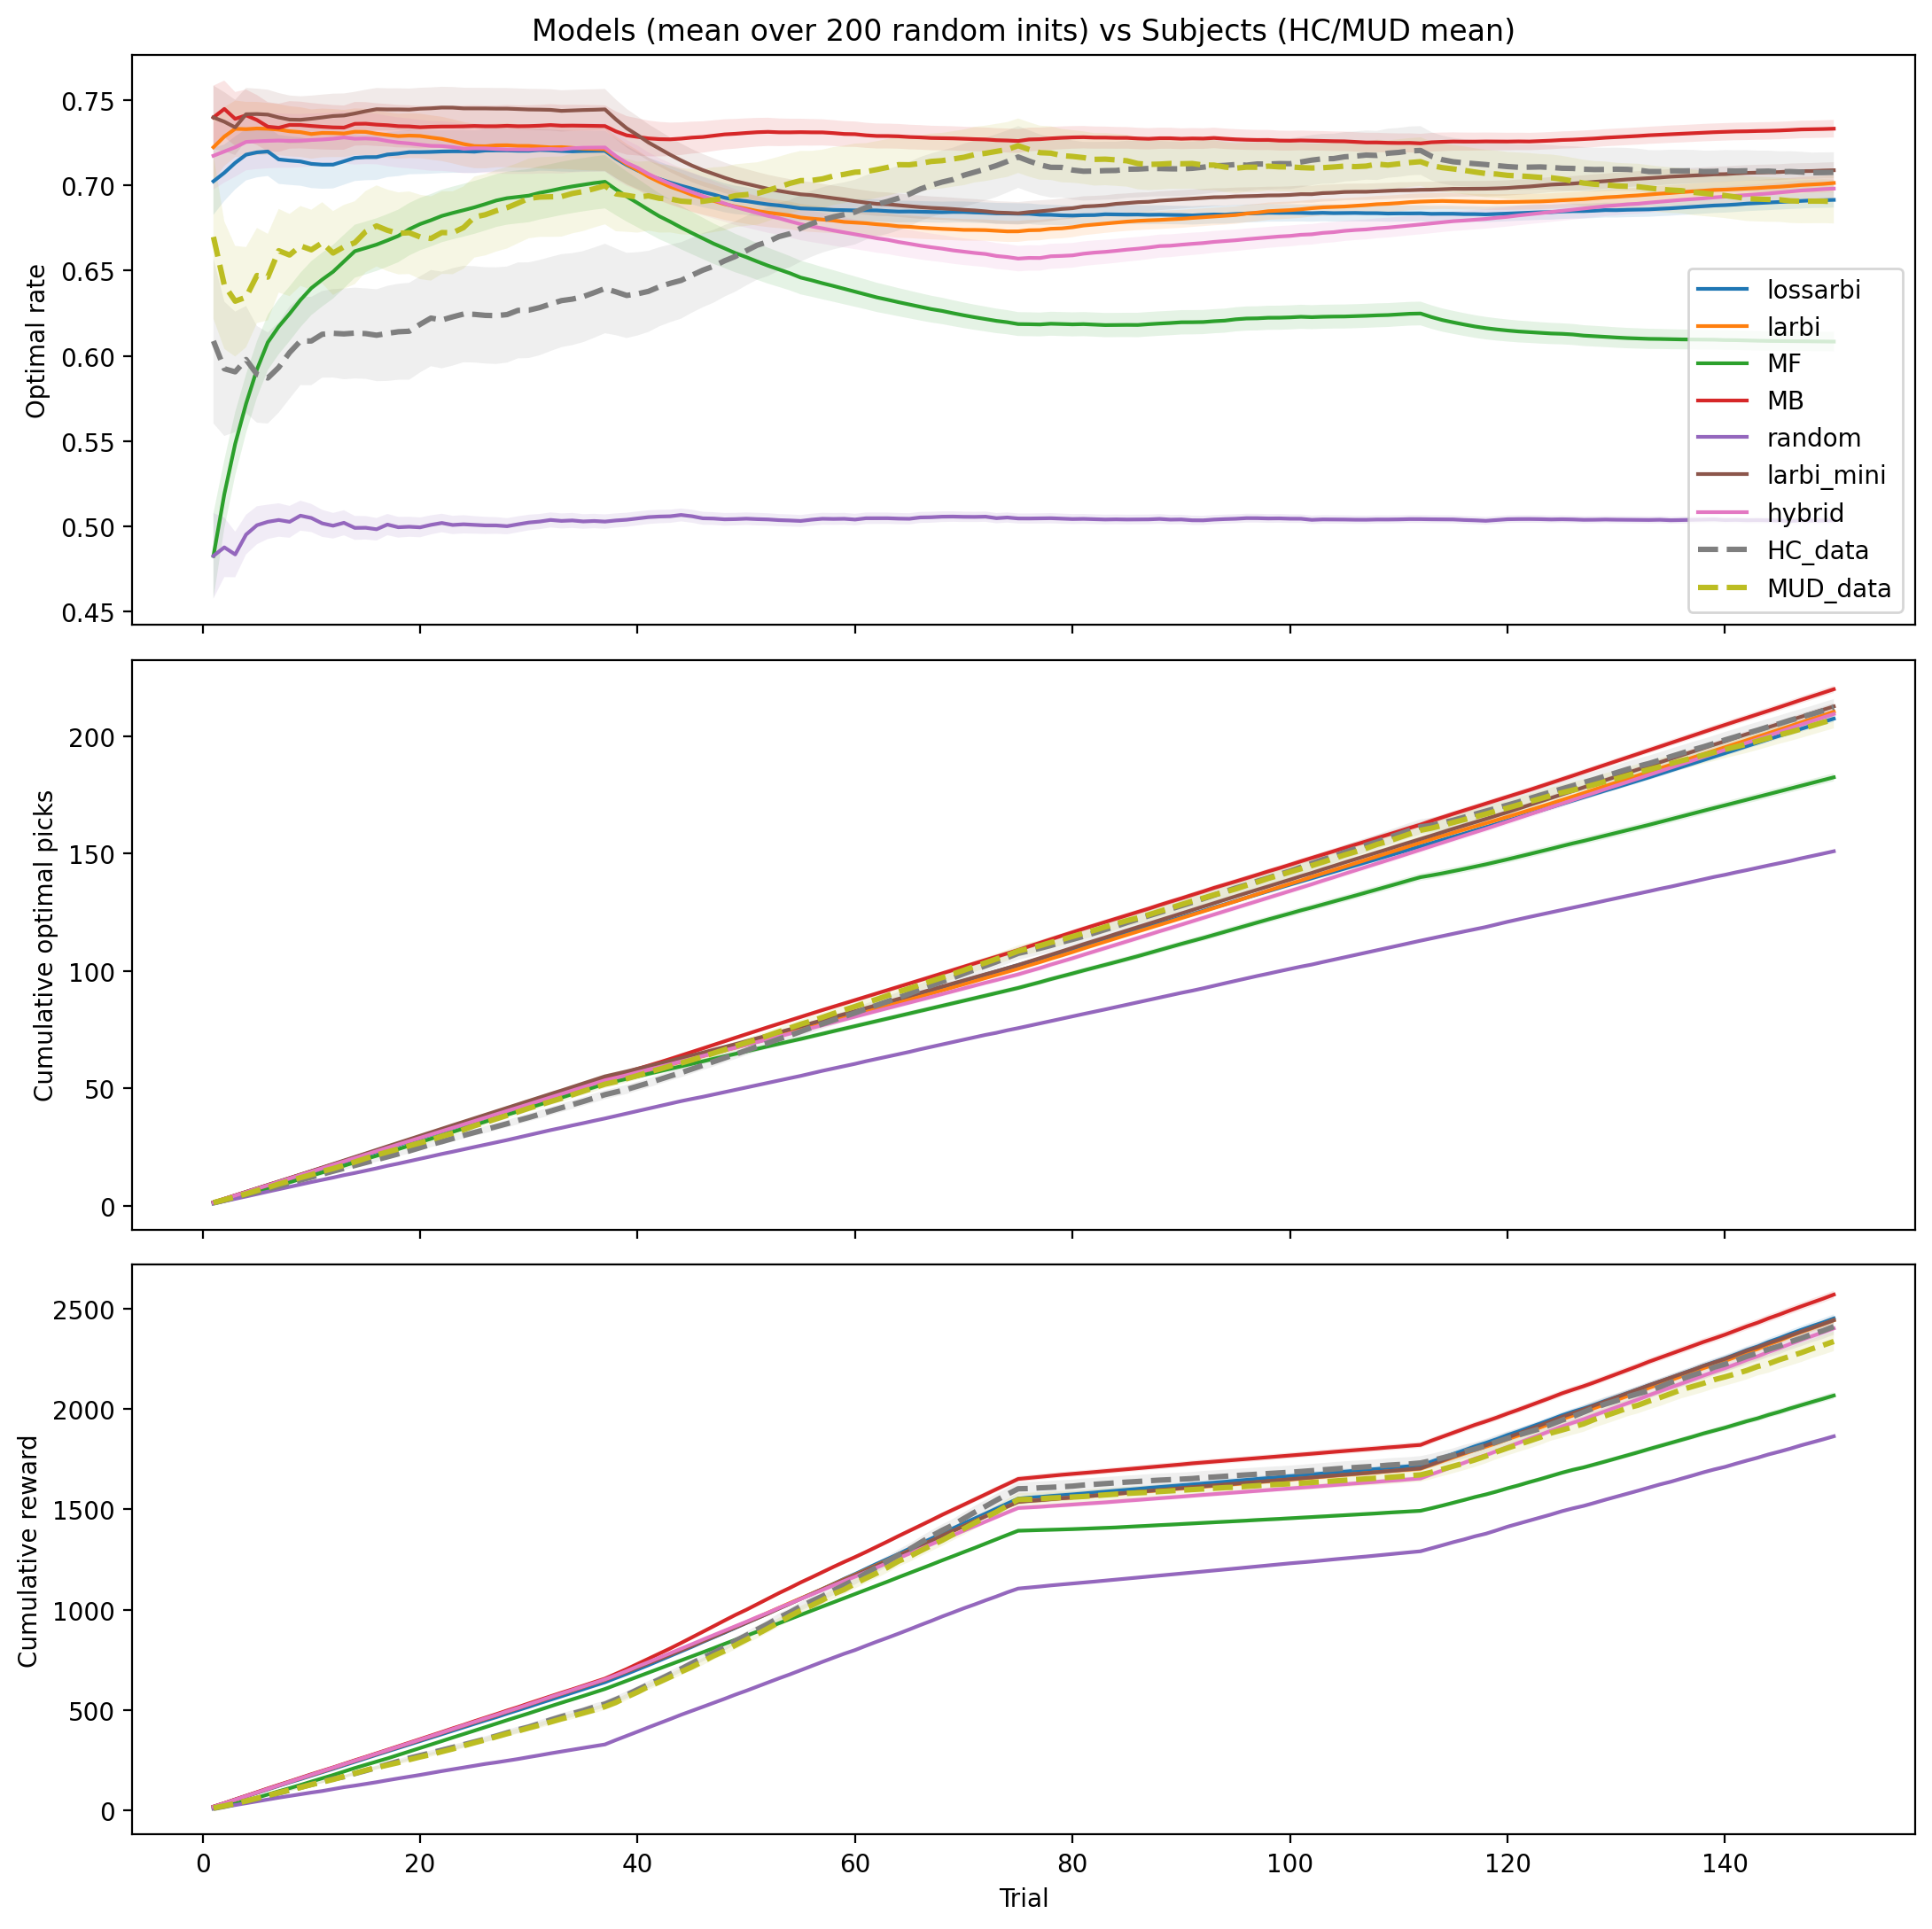

In [3]:
# ========= 配置 =========
N_REPS     = 200      # 每个模型随机初始化次数
N_EPISODE  = 150      # 仿真trial数
BASE_SEED  = 12345    # 基准随机种子（可复现）

MODELS = {
    "lossarbi": agent.lossarbi,
    "larbi":    agent.larbi,
    "MF":       agent.MF,
    "MB":       agent.MB,
    "random":   agent.randomagent,
    "larbi_mini": agent.larbi_mini,
    "hybrid": agent.hybrid,
}

METRICS = ["optimal_action", "optimal_rate", "accumulated_reward"]

# ========= 工具（参数采样 & 仿真均值） =========
def sample_params(agent_cls, rng):
    """从 agent 类的 pbnds 均匀采样一组参数字典；零参数模型返回 {}。"""
    if hasattr(agent_cls, "p_name") and hasattr(agent_cls, "pbnds") and len(agent_cls.p_name) == len(agent_cls.pbnds):
        vals = [rng.uniform(lo, hi) for (lo, hi) in agent_cls.pbnds]
        return {k: float(v) for k, v in zip(agent_cls.p_name, vals)}
    return {}

def run_model_mean_curves(agent_cls, n_reps=N_REPS, n_episode=N_EPISODE, base_seed=BASE_SEED):
    """对某个模型做 n_reps 次随机初始化仿真；返回三条指标的 mean/std（逐 trial）。"""
    stacks = {m: [] for m in METRICS}
    for r in range(n_reps):
        rng   = np.random.RandomState(base_seed + r)
        theta = sample_params(agent_cls, rng)
        out   = sim(agent_cls, theta, n_episode=n_episode, seed=base_seed + 10000 + r)  # 需已定义 sim()
        for m in METRICS:
            arr = np.asarray(out[m], dtype=float)
            assert len(arr) == n_episode, f"{m} 长度 {len(arr)} != n_episode {n_episode}"
            stacks[m].append(arr)
    means = {m: np.vstack(stacks[m]).mean(axis=0) for m in METRICS}
    stds  = {m: np.vstack(stacks[m]).std(axis=0)  for m in METRICS}
    return means, stds

# ========= 被试最优性（HC/MUD） =========
def _expected_reward(env: two_stage, s: int, a: int, C: int, W: int) -> float:
    p = np.asarray(env.t[s][a][C], dtype=float)
    r = np.asarray(env.r[W],       dtype=float)
    return float(np.dot(p, r))

def _optimal_a2(env: two_stage, s2: int, C: int, W: int):
    qs = [_expected_reward(env, s2, a, C, W) for a in range(env.nA)]
    return int(np.argmax(qs)), qs

def _optimal_a1(env: two_stage, C: int, W: int):
    # s0=0，先求每个二阶段状态的最优价值 V(s2)，再反推 Q(s0,a1)
    V = {}
    for s2 in (1, 2, 3, 4):
        a2_star, _ = _optimal_a2(env, s2, C, W)
        V[s2] = _expected_reward(env, s2, a2_star, C, W)
    qs = []
    for a1 in range(env.nA):
        p_s2 = np.asarray(env.t[0][a1][C], dtype=float)
        q = sum(p_s2[s2]*V[s2] for s2 in (1, 2, 3, 4))
        qs.append(q)
    return int(np.argmax(qs)), qs

def _block_certainty(t):
    # 0/1 对应 env.t 的两套转移（0->0.9, 1->0.5）
    if t < 37:   return 0
    if t < 75:   return 0
    if t < 112:  return 1
    return 1

def subject_curves(df, env=None):
    """给单被试 DataFrame 计算三条曲线。"""
    if env is None: env = two_stage()
    nT = len(df)
    opt_cnt = 0
    total_r = 0.0
    opt_arr, orate_arr, reward_arr = [], [], []
    dfr = df.reset_index(drop=True)
    for t in range(nT):
        W = int(dfr.at[t, 'g'])
        C = _block_certainty(t)
        a1 = int(dfr.at[t, 'a1'])
        s1 = int(dfr.at[t, 's1'])
        a2 = int(dfr.at[t, 'a2'])
        r2 = float(dfr.at[t, 'r2'])
        # stage1
        a1_star, _ = _optimal_a1(env, C, W)
        if a1 == a1_star: opt_cnt += 1
        # stage2
        a2_star, _ = _optimal_a2(env, s1, C, W)
        if a2 == a2_star: opt_cnt += 1
        total_r += r2
        opt_arr.append(opt_cnt)
        orate_arr.append(opt_cnt / (2*(t+1)))
        reward_arr.append(total_r)
    return {
        'optimal_action':       np.asarray(opt_arr, dtype=float),
        'optimal_rate':         np.asarray(orate_arr, dtype=float),
        'accumulated_reward':   np.asarray(reward_arr, dtype=float),
    }

def group_mean_curves(group_dict):
    """对一组被试取均值/标准差；返回 (means, stds, n_subj_per_metric)。"""
    stacks = {m: [] for m in METRICS}
    env = two_stage()
    for sid, df in group_dict.items():
        out = subject_curves(df, env=env)
        for m in METRICS:
            stacks[m].append(np.asarray(out[m], dtype=float))
    means = {m: np.vstack(stacks[m]).mean(axis=0) for m in METRICS}
    stds  = {m: np.vstack(stacks[m]).std(axis=0)  for m in METRICS}
    n_subj = {m: len(stacks[m]) for m in METRICS}
    return means, stds, n_subj

# ========= 跑起来（模型 + 被试组） =========
# 1) 模型均值
all_means, all_stds = {}, {}
for name, cls in MODELS.items():
    print(f"[{name}] running {N_REPS} reps …")
    means, stds = run_model_mean_curves(cls)
    all_means[name] = means
    all_stds[name]  = stds

# 2) 被试分组（ID 含 'Q' → MUD；不含 → HC）
import pickle
ALL = pickle.load(open('./PKL_DATA/ALL_SUBJECTS.pkl','rb'))
HC  = {sid: df for sid, df in ALL.items() if 'Q' not in sid.upper()}
MUD = {sid: df for sid, df in ALL.items() if 'Q'     in sid.upper()}
print(f"Split by 'Q': HC={len(HC)}  MUD={len(MUD)}  ALL={len(ALL)}")

hc_means, hc_stds, hc_n = group_mean_curves(HC)
md_means, md_stds, md_n = group_mean_curves(MUD)
all_means['HC_data']  = hc_means;  all_stds['HC_data']  = hc_stds
all_means['MUD_data'] = md_means;  all_stds['MUD_data'] = md_stds

# ========= 画图（3行子图 / 7条线） =========
fig, axes = plt.subplots(3, 1, figsize=(11, 11), sharex=True)
x = np.arange(1, N_EPISODE + 1)

ORDER  = list(MODELS.keys()) + ['HC_data', 'MUD_data']  # 5模型 + 2数据
STYLES = {'HC_data': dict(ls='--', lw=2.2), 'MUD_data': dict(ls='--', lw=2.2)}

# 1) optimal_rate
ax = axes[0]
for name in ORDER:
    y  = all_means[name]["optimal_rate"]
    denom = N_REPS if name in MODELS else (hc_n['optimal_rate'] if name=='HC_data' else md_n['optimal_rate'])
    se = all_stds[name]["optimal_rate"] / np.sqrt(max(denom,1))
    style = STYLES.get(name, {})
    ax.plot(x, y, label=name, **style)
    ax.fill_between(x, y - se, y + se, alpha=0.12)
ax.set_ylabel("Optimal rate")
ax.set_title(f"Models (mean over {N_REPS} random inits) vs Subjects (HC/MUD mean)")
ax.legend(loc="lower right")

# 2) optimal_action（累计最优次数）
ax = axes[1]
for name in ORDER:
    y  = all_means[name]["optimal_action"]
    denom = N_REPS if name in MODELS else (hc_n['optimal_action'] if name=='HC_data' else md_n['optimal_action'])
    se = all_stds[name]["optimal_action"] / np.sqrt(max(denom,1))
    style = STYLES.get(name, {})
    ax.plot(x, y, label=name, **style)
    ax.fill_between(x, y - se, y + se, alpha=0.12)
ax.set_ylabel("Cumulative optimal picks")

# 3) accumulated_reward（累计回报）
ax = axes[2]
for name in ORDER:
    y  = all_means[name]["accumulated_reward"]
    denom = N_REPS if name in MODELS else (hc_n['accumulated_reward'] if name=='HC_data' else md_n['accumulated_reward'])
    se = all_stds[name]["accumulated_reward"] / np.sqrt(max(denom,1))
    style = STYLES.get(name, {})
    ax.plot(x, y, label=name, **style)
    ax.fill_between(x, y - se, y + se, alpha=0.12)
ax.set_ylabel("Cumulative reward")
ax.set_xlabel("Trial")

plt.tight_layout()
plt.show()
